In [2]:
!pip install python-chess
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import glob
import os
import chess


  Obtaining dependency information for chess<2,>=1 from https://files.pythonhosted.org/packages/d6/d8/15cfcb738d2518daf04d34b23419bd359cbd8e09da50778ebac521774fc8/chess-1.10.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.4 MB/s eta 0:00:00


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d mallikarjunreddy3015/chessfendataset

100% 144M/144M [00:06<00:00, 29.1MB/s]
100% 144M/144M [00:06<00:00, 22.2MB/s]


In [6]:
import psutil

# Get system memory information
memory = psutil.virtual_memory()
print(f"Total RAM: {memory.total / (1024 ** 3):.2f} GB")
print(f"Used RAM: {memory.used / (1024 ** 3):.2f} GB")
print(f"Free RAM: {memory.free / (1024 ** 3):.2f} GB")


Total RAM: 58.87 GB
Used RAM: 1.48 GB
Free RAM: 55.58 GB


In [7]:
import zipfile

# Replace 'your-dataset.zip' with the actual zip file name
with zipfile.ZipFile('/content/chessfendataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/chessfendataset')


In [8]:
dataframe = pd.read_csv('/content/chessfendataset/chessData.csv')

In [9]:
!nvidia-smi


Tue Oct  3 19:10:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [10]:
dataframe.head()
d=dataframe

In [11]:
d.shape
d1=d.iloc[0:10000000 ,:]
d1.shape
d1 = d1[~d1['Evaluation'].str.contains('\ufeff|#', na=False)]
d1['Evaluation'] = pd.to_numeric(d1['Evaluation'].str.replace('[^\d.-]', '', regex=True), errors='coerce')

In [12]:
d1['Scaled_Evaluation'] = 1000 * (2 * (d1['Evaluation'] +7000) / (14000) - 1)

In [15]:


def generate_bitboard_with_moves(fen):
    board = chess.Board(fen)

    bitboards = np.zeros((15, 8, 8), dtype=np.int8)

    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is not None:
            piece_type = piece.piece_type - 1 if piece.color == chess.WHITE else piece.piece_type + 5
            if(piece_type<6):
               bitboards[piece_type, square // 8, square % 8] = (piece_type +1)
            else:
                 bitboards[piece_type, square // 8, square % 8] = -(piece_type -5)

    legal_moves = [move.from_square for move in board.legal_moves]

    for from_square in legal_moves:

        bitboards[12, from_square // 8, from_square % 8] = 1 if board.turn == chess.WHITE else -1

    # Add information about en passant square
    if board.has_legal_en_passant():
        ep_square = board.ep_square
        bitboards[13, ep_square // 8, ep_square % 8] = 1 if board.turn == chess.WHITE else -1

    # Add bitboards for all black and white pieces
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece is not None:
            piece_type = piece.piece_type - 1 if piece.color == chess.WHITE else -(piece.piece_type + 1)
            bitboards[14, square // 8, square % 8] = piece_type + 1


    return bitboards

bitboard_dataset = [generate_bitboard_with_moves(fen) for fen in d1['FEN']]
# print(generate_bitboard_with_moves(d1["FEN"][1]))


In [ ]:
# import pandas as pd
# import chess
# import chess.svg
# from IPython.display import display, SVG

# # Assuming d1 is your DataFrame
# for index, row in d1.iterrows():
#     if row['Scaled_Evaluation'] < -5000:
#         fen = row['FEN']
#         board = chess.Board(fen)
#         print(f"FEN: {fen}")
#         print(f"Scaled_Evaluation: {row['Scaled_Evaluation']}")
#         print("Chessboard:")
#         display(SVG(chess.svg.board(board=board, size=500)))
#         print("\n")


In [ ]:
# import numpy as np
# import chess

# def generate_bitboard_with_moves(fen):
#     board = chess.Board(fen)

#     # Initialize empty 3D matrix of bitboards for each piece type
#     bitboards = np.zeros((12, 8, 8), dtype=np.int8)

#     # Iterate over all squares on the board
#     for square in chess.SQUARES:
#         piece = board.piece_at(square)

#         if piece is not None:
#             # Determine piece type
#             piece_type = piece.piece_type - 1 if piece.color == chess.WHITE else piece.piece_type + 5

#             # Mark the piece's position on the bitboard
#             bitboards[piece_type, square // 8, square % 8] = (piece_type + 1)*11

#             # Generate legal moves for the piece at the square
#             legal_moves = [move.to_square for move in board.legal_moves if move.from_square == square]

#             # Mark legal moves on the bitboard
#             for move_square in legal_moves:
#                 bitboards[piece_type, move_square // 8, move_square % 8] = piece_type + 1

#     return bitboards
# bitboard_dataset = [generate_bitboard_with_moves(fen) for fen in d1['FEN']]

In [16]:
bitboard_dataset=np.array(bitboard_dataset)
print(bitboard_dataset[20])

[[[ 0  0  0  0  0  0  0  0]
  [ 1  1  0  0  0  0  1  1]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  1  0  1  0  0]
  [ 0  0  0  0  1  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  2  0  0  0]
  [ 0  0  0  0  0  2  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  0  0  0  0  0  0  0]
  [ 0  0  0  3  0  0  0  0]
  [ 0  0  0  3  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 4  0  0  0  0  0  0  4]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  0  0  5  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0 

In [17]:
# labels=d1['Evaluation']
labels=d1['Scaled_Evaluation']

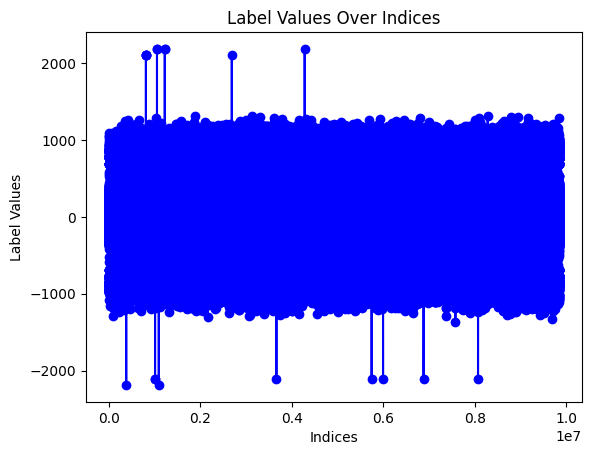

In [18]:
import matplotlib.pyplot as plt

# Assuming 'labels' is your list or array of labels
indices = list(range(len(labels)))

plt.plot(indices, labels, marker='o', linestyle='-', color='b')
plt.title('Label Values Over Indices')
plt.xlabel('Indices')
plt.ylabel('Label Values')
plt.show()


In [19]:
np.save('/content/bitboard_dataset_10M.npy', bitboard_dataset)
np.save('/content/labels_dataset_10M.npy', labels)

# bitboard_dataset=np.load("/content/chess-numpy-dataset/bitboard_dataset_1M.npy")
# labels=np.load("/content/chess-numpy-dataset/labels_dataset.npy")

In [25]:
!pip install google-cloud-storage
import os

# Replace 'path/to/service-account-key.json' with the path to your service account key file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/gleaming-modem-400906-3780658b0f47.json'

from google.cloud import storage

# Replace 'your-bucket-name' with the name of your Google Cloud Storage bucket
bucket_name = 'chess_data_all'

# Save the array to a binary file
file_path = '/content/labels_dataset_10M.npy'

# Create a Google Cloud Storage client
client = storage.Client()

# Specify the destination blob (file) in your bucket
blob_name = 'labels_dataset_10M.npy'

# Upload the file to the bucket
bucket = client.get_bucket(bucket_name)
blob = bucket.blob(blob_name)
blob.upload_from_filename(file_path)

print(f"File uploaded to: gs://{bucket_name}/{blob_name}")


File uploaded to: gs://chess_data_all/labels_dataset_10M.npy


In [21]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf


bitboard_dataset = np.array(bitboard_dataset)
bitboard_dataset, labels = shuffle(bitboard_dataset, labels, random_state=20)

X_train, X_test, y_train, y_test = train_test_split(bitboard_dataset, labels, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], 15, 8, 8, 1)
X_test = X_test.reshape(X_test.shape[0], 15, 8, 8, 1)

# Input layer
input_layer = layers.Input(shape=(15, 8, 8, 1))

# Parallel convolutional layers
conv1 = layers.Conv3D(8, (15, 8, 8), activation='relu')(input_layer)
conv2 = layers.Conv3D(4, (15, 5, 5), activation='relu')(input_layer)
conv3 = layers.Conv3D(8, (1, 8, 8), activation='relu')(input_layer)

# Flatten the outputs of convolutional layers
flatten1 = layers.Flatten()(conv1)
flatten2 = layers.Flatten()(conv2)
flatten3 = layers.Flatten()(conv3)

# Concatenate the outputs of parallel convolutions
merged = layers.concatenate([flatten1,flatten2, flatten3], axis=-1)

# Additional layers
batch_norm1 = layers.BatchNormalization()(merged)
flatten = layers.Flatten()(batch_norm1)

dense1 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten)
batch_norm2 = layers.BatchNormalization()(dense1)

dense2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(batch_norm2)
batch_norm3 = layers.BatchNormalization()(dense2)

dense3 = layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(batch_norm3)
batch_norm4 = layers.BatchNormalization()(dense3)


# Output layer
output_layer = layers.Dense(1)(batch_norm4)


# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=300, batch_size=10000, validation_split=0.1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Mean Absolute Error:", mae)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 8, 8, 1)]        0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 1, 1, 1, 8)           7688      ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 1, 4, 4, 4)           1504      ['input_1[0][0]']             
                                                                                                  
 conv3d_2 (Conv3D)           (None, 15, 1, 1, 8)          520       ['input_1[0][0]']             
                                                                                              

KeyboardInterrupt: ignored

In [22]:

model.save('/content/drive/MyDrive/model1.keras')


FileNotFoundError: ignored